In [38]:
import csv
import os
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.quantization
import time

RANDOM_SEED = 42
torch.manual_seed(42)

In [12]:
dataset = "model/keypoint_classifier/keypoint.csv"
model_save_path = "model/keypoint_classifier/keypoint_classifier.hdf5"
tflite_save_path = "model/keypoint_classifier/keypoint_classifier.tflite"

In [13]:
NUM_CLASSES = 4

In [14]:
X_dataset = np.loadtxt(
    dataset, delimiter=",", dtype="float32", usecols=list(range(1, (21 * 2) + 1))
)
X_dataset = torch.from_numpy(X_dataset)

In [15]:
y_dataset = np.loadtxt(dataset, delimiter=",", dtype="int32", usecols=(0))
y_dataset = torch.from_numpy(y_dataset)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED
)

In [19]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(21 * 2, 20)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(20, 10)
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(10, NUM_CLASSES)

    def forward(self, x):
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = F.softmax(self.fc3(x), dim=1)
        return x


model = Model()

In [20]:
summary(model, input_size=(21 * 2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]             860
           Dropout-2                   [-1, 20]               0
            Linear-3                   [-1, 10]             210
           Dropout-4                   [-1, 10]               0
            Linear-5                    [-1, 4]              44
Total params: 1,114
Trainable params: 1,114
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [63]:
# Define the number of epochs
num_epochs = 1000  # replace 100 with the number of epochs you want

# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=10, verbose=True
)

# Initialize the minimum validation loss
min_val_loss = np.inf

for epoch in range(num_epochs):
    # Training and validation steps go here

    # After each epoch, you can save the model if it has the lowest validation loss so far
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), model_save_path)

    # Update the learning rate
    scheduler.step(val_loss)

c:\Python310\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [64]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters())

In [65]:
# Convert the numpy arrays to PyTorch tensors and create dataloaders
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128)

# Training loop
for epoch in range(1000):
    model.train()
    for inputs, labels in train_loader:
        labels = labels.long()  # Convert labels to Long
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            labels = labels.long()  # Convert labels to Long
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

    # Save the model if validation loss decreases
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), model_save_path)

    # Update the learning rate
    scheduler.step(val_loss)

In [66]:
model.eval()
with torch.no_grad():
    inputs = X_test  # No need to convert to tensor
    labels = y_test.long()  # Convert labels to Long
    outputs = model(inputs)
    val_loss = criterion(outputs, labels)
    _, preds = torch.max(outputs, 1)
    val_acc = torch.sum(preds == labels.data) / len(labels)

In [67]:
# Define the model
model = Model()

# Load the saved model
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [68]:
# Inference test
model.eval()
with torch.no_grad():
    inputs = torch.from_numpy(np.array([X_test[0]]))
    outputs = model(inputs)
    predict_result = torch.squeeze(outputs)
    _, predicted_class = torch.max(predict_result, 0)

print(predict_result)
print(predicted_class.item())

tensor([1., 0., 0., 0.])
0


# Confusion Matrix


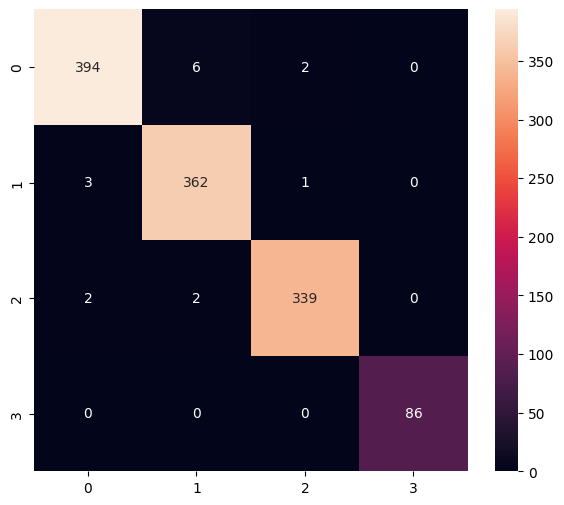

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       402
           1       0.98      0.99      0.98       366
           2       0.99      0.99      0.99       343
           3       1.00      1.00      1.00        86

    accuracy                           0.99      1197
   macro avg       0.99      0.99      0.99      1197
weighted avg       0.99      0.99      0.99      1197



In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt="g", square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print("Classification Report")
        print(classification_report(y_true, y_pred))


model.eval()
with torch.no_grad():
    inputs = X_test  # No need to convert to tensor
    outputs = model(inputs)
    _, y_pred = torch.max(outputs, 1)

print_confusion_matrix(y_test.numpy(), y_pred.numpy())

In [70]:
torch.save(model.state_dict(), model_save_path)

In [71]:
# Save the entire model
torch.save(model, model_save_path)

# Load the entire model
model = torch.load(model_save_path)

# Set the model to evaluation mode
model.eval()

Model(
  (fc1): Linear(in_features=42, out_features=20, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=10, out_features=4, bias=True)
)

# Inferenece Test


In [72]:
import os
print(os.path.exists(tflite_save_path))

True


In [73]:
# Load the quantized model
model = torch.load(model_save_path)

# Set the model to evaluation mode
model.eval()


Model(
  (fc1): Linear(in_features=42, out_features=20, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=10, out_features=4, bias=True)
)

In [74]:
# Get the input tensor
input_tensor = next(iter(model.parameters())).data

# Get the output tensor
model.eval()
with torch.no_grad():
    output_tensor = model(input_tensor)

In [75]:
# Set the input tensor
inputs = torch.from_numpy(np.array([X_test[0]]))

In [61]:
# Start the timer
start_time = time.time()

# Perform inference
model.eval()
with torch.no_grad():
    outputs = model(inputs)

# Print the time taken
print("Time taken: %s seconds" % (time.time() - start_time))

Time taken: 0.006448984146118164 seconds


In [80]:
# Assuming `outputs` is your model's output

# Print the model's output
print("Model's output:")
print(outputs)

# Get the predicted class for each input
predicted_classes = torch.argmax(outputs, dim=1)

# Print the predicted classes
print("\nPredicted classes:")
print(predicted_classes)

# Get the confidence score of the predicted class for each input
confidence_scores, _ = torch.max(outputs, dim=1)

# Print the confidence scores
print("\nConfidence scores:")
print(confidence_scores)

# Remove single-dimensional entries from the shape of the output
outputs_squeezed = torch.squeeze(outputs)

# Print the squeezed output
print("\nSqueezed output:")
print(outputs_squeezed.tolist())

# Get the index of the maximum value
max_index = torch.argmax(outputs_squeezed)

# Print the index of the maximum value
print("\nIndex of the maximum value:")
print(max_index.item())

Model's output:
tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.1100e-25, 1.0000e+00, 1.1494e-19, 5.0518e-35],
        ...,
        [1.9133e-11, 1.0000e+00, 1.0122e-13, 1.6292e-21],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.6675e-43, 0.0000e+00, 0.0000e+00]])

Predicted classes:
tensor([0, 0, 1,  ..., 1, 1, 0])

Confidence scores:
tensor([1., 1., 1.,  ..., 1., 1., 1.])

Squeezed output:
[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [9.10999548923089e-25, 1.0, 1.1493584138544822e-19, 5.051800045113425e-35], [1.0, 0.0, 1.401298464324817e-45, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0017576829995959997, 0.00038453267188742757, 0.0006573953432962298, 0.9972003698348999], [9.805921643121083e-36, 1.0, 4.3285663950081944e-38, 0.0], [2.301403129008274e-15, 3.452360342048877e-10, 1.0, 1.4372750404188438e-19], [1.0, 0.0, 0.0, 0.0], [1.0, 2.662436446469606e-35, 5.983544442666969e-43, 0.0], [